In [1]:
!sudo pip3 install -U spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!python -m spacy download es_core_news_lg

2022-08-21 11:56:11.883616: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 568.0 MB 7.1 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')


In [1]:
# IMPORTS
import spacy
import scipy
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.metrics import precision_recall_fscore_support, classification_report

In [2]:
# Load the Drive helper and mount
drive.mount('/content/drive')
sst_home='drive/My Drive/TFM/'

Mounted at /content/drive


In [3]:
data_a = pd.read_csv(sst_home+"Data/new_parmex_train.csv") # 7382
data_a = data_a.dropna()

data_b = pd.read_csv(sst_home+"Data/translated_train.tsv", sep='\t') # 49129
data_b = data_b.dropna()
data_b = data_b.reset_index(drop=True)
data_b = data_b.rename(columns={'label': 'Label', 'sentence1': 'Text1', 'sentence2': 'Text2'})

df_pos = data_b[data_b["Label"] == 1].sample(10000, random_state=1)


print(len(data_a))
print(len(df_pos))

7382
10000


In [ ]:
paw_mex_data = pd.concat([
    data_a, 
    df_pos]).reset_index(drop=True)

paw_mex_data = paw_mex_data.sample(
    frac=1,
    random_state=1).reset_index(drop=True)

print(paw_mex_data.columns)
print(paw_mex_data.index)

Index(['id', 'Text1', 'Text2', 'Label'], dtype='object')
RangeIndex(start=0, stop=17382, step=1)


Positivos = 11282
Negativos = 6100
----------------------------


([<matplotlib.patches.Wedge at 0x7fe3992c2050>,
 [Text(0.49649995100868205, 0.9815741432252464, 'Negative'),
  Text(-0.4964998591070757, -0.9815741897109225, 'Positive')])

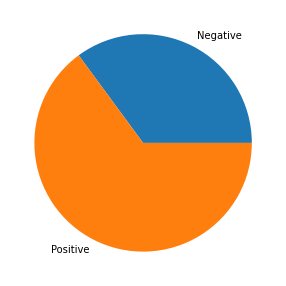

In [ ]:
#data = pd.read_csv(sst_home+"/PARMEX_2022-main-new/new_parmex_train.csv") # 7601

text_1_df = paw_mex_data["Text1"]
text_2_df = paw_mex_data["Text2"]
label_df = paw_mex_data["Label"]

print("Positivos =", len(paw_mex_data[paw_mex_data["Label"] == 1]))
print("Negativos =", len(paw_mex_data[paw_mex_data["Label"] == 0]))
print("----------------------------")

fig = plt.figure(figsize =(5, 5))
plot_data = [len(paw_mex_data[paw_mex_data["Label"] == 0]), len(paw_mex_data[paw_mex_data["Label"] == 1])]
plt.pie(plot_data, labels = ["Negative", "Positive"])

In [21]:
#data = pd.read_csv(sst_home+"/PARMEX_2022-main-new/new_parmex_train.csv") # 7601

text_1_df = data_a["Text1"]
text_2_df = data_a["Text2"]
label_df = data_a["Label"]

In [22]:
nlp = spacy.load("es_core_news_lg")

In [23]:
tokens_1=[]
tokens_2=[]
for i, text in text_1_df.items(): 
    tok_1 = nlp(text)
    tok_2 = nlp(text_2_df[i])
    tokens_1.append(tok_1.vector)
    tokens_2.append(tok_2.vector)

print(len(tokens_1), len(tokens_2), len(label_df))

7382 7382 7382


In [24]:
def cosine_distance_wordembedding(s1, s2):
    """gets two texts, obtains their word embeddings and then returns its cosine distance"""

    cosine = 1 - scipy.spatial.distance.cosine(s1, s2)
    return round((cosine),2)

In [29]:
predicted = []
i = 0
for tok1 in tokens_1:
  tok2 = tokens_2[i]
  pred = cosine_distance_wordembedding(tok1, tok2)
  if pred < 0.959: #0.959
    predicted.append(0)
  else:
    predicted.append(1)
  i = i+1

In [13]:
pos = 0
neg = 0
for i in predicted:
  if i == 1:
    pos+=1
  else:
    neg+=1

print(f"{pos}/11282 Positives")
print(f"{neg}/6100 Negatives")

45032/11282 Positives
4097/6100 Negatives


In [30]:
# PAR-MEX
predicted_series = pd.Series(predicted)

print(precision_recall_fscore_support(label_df, predicted_series, average=None))
print("-------------------------------------------------")
print( classification_report(label_df, predicted_series))

# 0.85

# 0       0.92      0.54      0.68      6100
# 1       0.26      0.78      0.39      1282
#    accuracy                           0.58      7382

# 0.9

# 0       0.91      0.91      0.91      6100
# 1       0.57      0.58      0.58      1282
#    accuracy                           0.85      7382

# 0.95

# 0       0.86      1.00      0.92      6100
# 1       1.00      0.22      0.36      1282
#    accuracy                           0.86      7382

(array([0.85949831, 0.9965035 ]), array([0.99983607, 0.22230889]), array([0.92437102, 0.36352041]), array([6100, 1282]))
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      6100
           1       1.00      0.22      0.36      1282

    accuracy                           0.86      7382
   macro avg       0.93      0.61      0.64      7382
weighted avg       0.88      0.86      0.83      7382



In [20]:
# PAW-X
predicted_series = pd.Series(predicted)

print(precision_recall_fscore_support(label_df, predicted_series, average=None))
print("-------------------------------------------------")
print( classification_report(label_df, predicted_series))

# 0.85 

# 0       0.61      0.04      0.08     27445
# 1       0.44      0.96      0.61     21684
#    accuracy                           0.45     49129

# 0.9

# 0       0.60      0.09      0.16     27445
# 1       0.45      0.92      0.60     21684
#    accuracy                           0.46     49129

# 0.95

# 0       0.59      0.28      0.38     274453
# 1       0.45      0.75      0.56     21684
#    accuracy                           0.49     49129



(array([0.58743313, 0.45203034]), array([0.28409546, 0.74746357]), array([0.38297559, 0.56336462]), array([27445, 21684]))
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.59      0.28      0.38     27445
           1       0.45      0.75      0.56     21684

    accuracy                           0.49     49129
   macro avg       0.52      0.52      0.47     49129
weighted avg       0.53      0.49      0.46     49129



In [ ]:
# PAW-MEX 17K
predicted_series = pd.Series(predicted)

print(precision_recall_fscore_support(label_df, predicted_series, average=None))
print("-------------------------------------------------")
print( classification_report(label_df, predicted_series))

# 0.9 --> 0.89 0.86 0.91
# 0.95 --> 0.83 0.81 0.85
# 0.97 --> 0.75 0.74 0.76

(array([0.63090928, 0.99987038]), array([0.99983607, 0.68374402]), array([0.77364115, 0.81212823]), array([ 6100, 11282]))
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      1.00      0.77      6100
           1       1.00      0.68      0.81     11282

    accuracy                           0.79     17382
   macro avg       0.82      0.84      0.79     17382
weighted avg       0.87      0.79      0.80     17382



In [ ]:
predicted_series = pd.Series(predicted)

print(precision_recall_fscore_support(label_df, predicted_series, average=None))
print("-------------------------------------------------")
print( classification_report(label_df, predicted_series))

# 0.99 --> 0.65 0.43 0.57
# 0.98 --> 0.60 0.50 0.56
# 0.97 --> 0.55 0.53 0.54

(array([0.64122162, 0.46203757]), array([0.5667475 , 0.53989863]), array([0.60168881, 0.49794278]), array([34638, 23873]))
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.57      0.60     34638
           1       0.46      0.54      0.50     23873

    accuracy                           0.56     58511
   macro avg       0.55      0.55      0.55     58511
weighted avg       0.57      0.56      0.56     58511



Text(0.5, 0, 'predicted label')

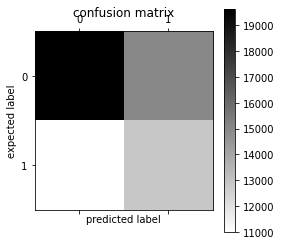

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 

plt.matshow(confusion_matrix(label_df, predicted_series), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [ ]:
labels = ['negative', 'positive']

pd.DataFrame(confusion_matrix(label_df, predicted_series), index=labels, columns=labels)

,negative,positive
negative,19631,15007
positive,10984,12889
